## Analyzing Raw Data

In [1]:
## Import data
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import sklearn

PRESSURE_PATH = '/Users/jiujiu/Desktop/496_New_Data/pressure/'   # pressure data
SATURATION_PATH = '/Users/jiujiu/Desktop/496_New_Data/saturation/' # saturation data
PRODUCTION_PATH = '/Users/jiujiu/Desktop/496_New_Data/production/' # production data
ROCK_PATH = '/Users/jiujiu/Desktop/496_New_Data/rock/'

def pullseries(PATH, NAME, index_list):
    # input: NAME - 'saturation' or 'pressure'
    data = []
    for i in index_list:
        temp_data = np.loadtxt(PATH+NAME+str(i)+'.txt',delimiter = ',')
        #temp_data = np.reshape(temp_data,(75,60,220),order ='F')
        data.append(temp_data)
    data = np.float32(data)
    # restructure data into long array (total snapshots , 13200)
    # total snapshots = n X 75
    # 13200 = total grid points = 60 X 220
    data = data.reshape((data.shape[0]*data.shape[1],data.shape[2])) 
    return data

def pullporosity(ROCK_PATH, index_list):
    data = []
    for i in index_list:
        temp_data = np.loadtxt(ROCK_PATH + '/rock'+str(i)+'.txt', delimiter=',')
        data.append(temp_data[[0]])
    data = np.float32(data)
    data = data.reshape((data.shape[0]*data.shape[1],data.shape[2])) 
    return data

# function to compare resulting sequential states
def animate_compare(y1,y2):
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    plt.ion()
    fig.show()
    fig.canvas.draw()
    for i in range(len(y1)):    
        ax1.clear()
        ax1.imshow(np.reshape(y1[i,:],(60,220),order ='F'))
        ax2.clear()
        ax2.imshow(np.reshape(y2[i,:],(60,220),order ='F'))
        fig.canvas.draw()
        plt.pause(0.05)
# plt.title('Water Saturation')
# plt.savefig('Saturation Plot X_1.png')

def animate_single(X):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    plt.ion()
    fig.show()
    fig.canvas.draw()
    for i in range(len(X)):    
        ax1.clear()
        ax1.imshow(np.reshape(X[i,:],(60,220),order ='F'))
        fig.canvas.draw()
        plt.pause(0.05)
        
def animate_encoded(X,decoder,index_range):
    # sanity check on stacked encoded space
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    plt.ion()
    fig.show()
    fig.canvas.draw()
#     print(X.shape)
    decoded_X = decoder.predict(X[:,:,:,index_range])
#     print(decoded_X)
    for i in range(len(decoded_X)):
        ax1.clear()
        ax1.imshow(np.reshape(decoded_X[i],(60,220),order = 'F'))
        fig.canvas.draw()
        plt.pause(0.01)

<IPython.core.display.Javascript object>


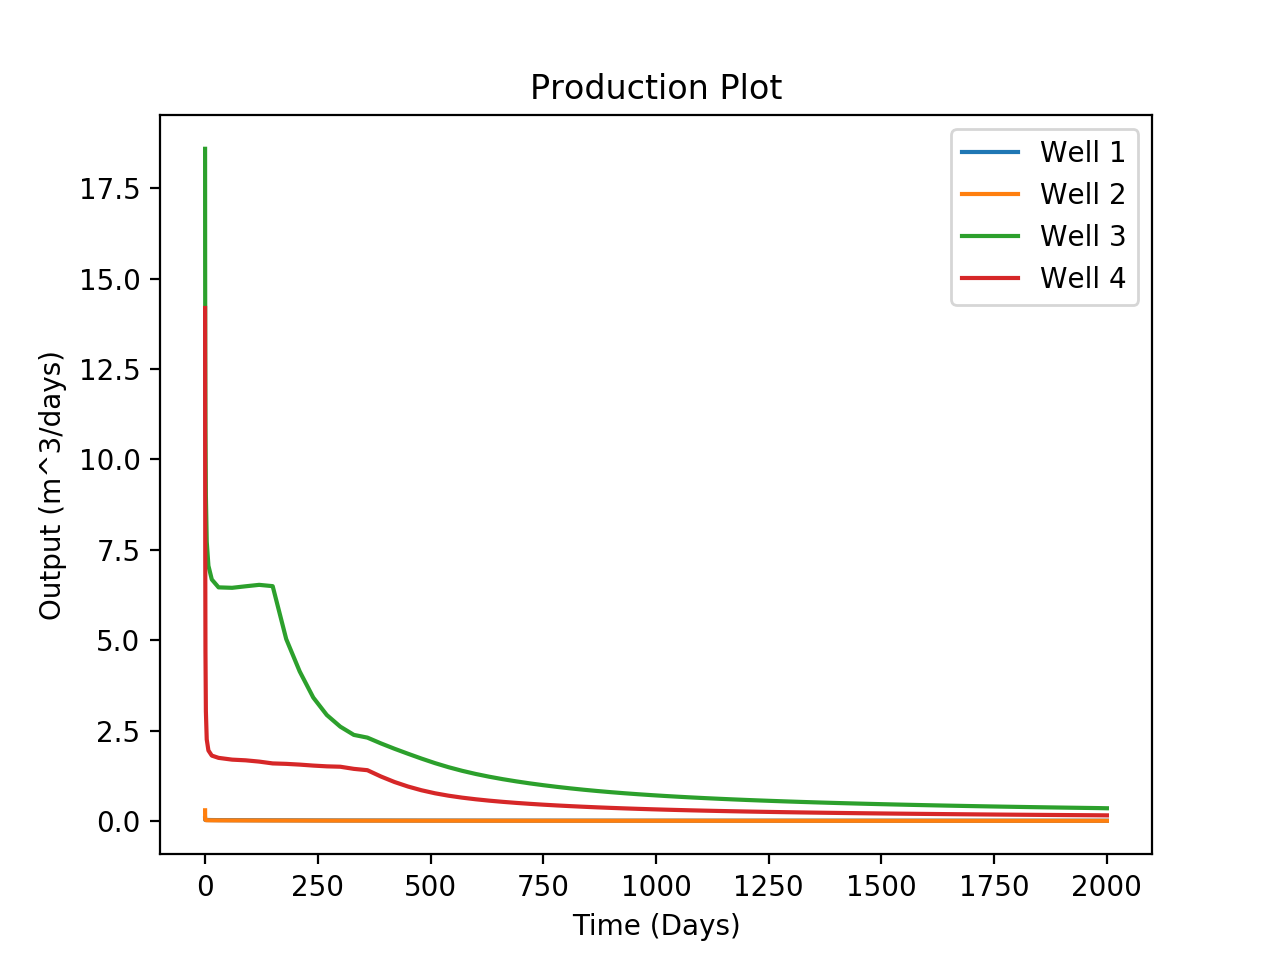

In [19]:
# check production data
Prod_unsized = np.loadtxt(PRODUCTION_PATH + '/production20.txt')
Prod_unsized_2 = np.loadtxt(PRODUCTION_PATH + '/production30.txt')
Prod_resized = np.array([Prod_unsized[:,0]/3600.0/24.0, 
                         Prod_unsized[:,1]*3600*24,
                         Prod_unsized[:,2]*3600*24,
                         Prod_unsized[:,3]*3600*24,
                         Prod_unsized[:,4]*3600*24])
Prod_resized_2 = np.array([Prod_unsized_2[:,0]/3600.0/24.0, 
                         Prod_unsized_2[:,1]*3600*24,
                         Prod_unsized_2[:,2]*3600*24,
                         Prod_unsized_2[:,3]*3600*24,
                         Prod_unsized_2[:,4]*3600*24])
well_1 = plt.plot(Prod_resized[0,],Prod_resized[1,],label='Well 1')
well_2 = plt.plot(Prod_resized[0,],Prod_resized[2,],label='Well 2')
well_3 = plt.plot(Prod_resized[0,],Prod_resized[3,],label='Well 3')
well_4 = plt.plot(Prod_resized[0,],Prod_resized[4,],label='Well 4')
plt.title('Production Plot')
# plt.yscale('log')
plt.xlabel('Time (Days)')
plt.ylabel('Output (m^3/days)')
plt.legend()
plt.savefig('Production Plot2.png')

<IPython.core.display.Javascript object>


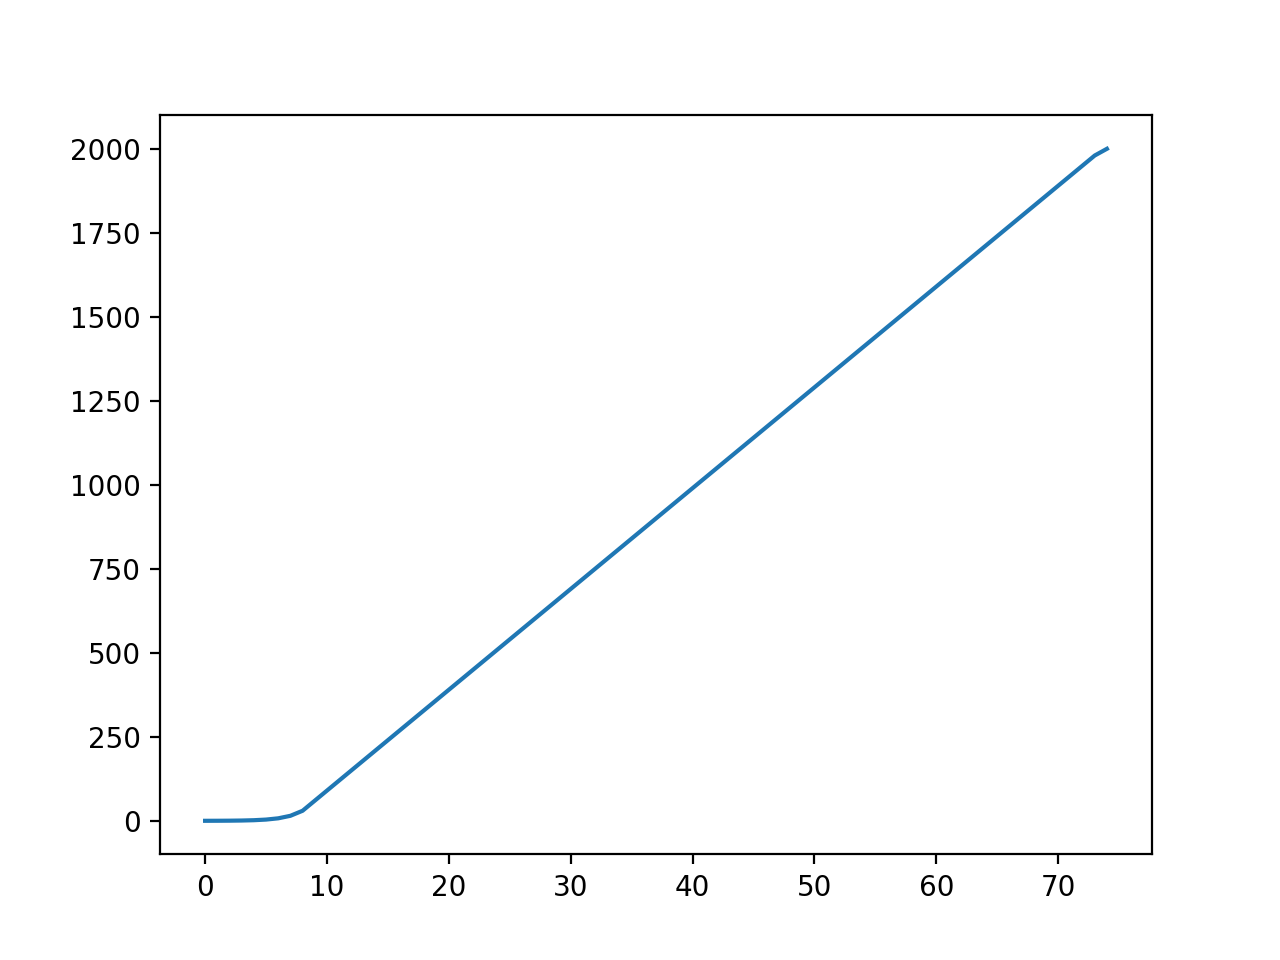

In [20]:
plt.figure()
plt.plot(np.arange(len(Prod_resized[0,])),Prod_resized[0,])

## Pull Data and Reshape for CNN

In [2]:
# Specify files to read for testing and training
train_files = np.arange(1,81)
test_files = np.arange(81,101)

In [16]:
# pull porosity from Rock files
RTRAIN = pullporosity(ROCK_PATH, train_files)
RTEST = pullporosity(ROCK_PATH, test_files)
# reshape porosity data to feed into autoencoder (channel last)
Rtrain = RTRAIN
Rtest = RTEST
Rtrain_reshaped = np.reshape(Rtrain,(len(Rtrain), 60, 220, 1),order= 'F')
Rtest_reshaped = np.reshape(Rtest,(len(Rtest), 60, 220, 1),order= 'F')

In [3]:
# pull saturation data
STRAIN = pullseries(SATURATION_PATH, 'saturaton', train_files)
STEST = pullseries(SATURATION_PATH, 'saturaton', test_files)

Strain = STRAIN
Stest = STEST
Strain_reshaped = np.reshape(Strain,(len(Strain), 60, 220, 1),order= 'F')
Stest_reshaped = np.reshape(Stest,(len(Stest), 60, 220, 1),order= 'F')

In [ ]:
# pull pressure data
PTRAIN = pullseries(PRESSURE_PATH, 'pressure', train_files)
PTEST = pullseries(PRESSURE_PATH, 'pressure', test_files)
# scale original data
Ptrain, Pscaler = scale_data(PTRAIN) 
Ptest = Pscaler.transform(PTEST)
Ptrain_reshaped = np.reshape(Ptrain,(len(Ptrain), 60, 220, 1),order= 'F')
Ptest_reshaped = np.reshape(Ptest,(len(Ptest), 60, 220, 1),order= 'F')

In [31]:
# sanity check for first pass of data
# here pressure data is checked
print(Strain_reshaped.shape) # reshaped Saturation: [75, 60, 220, 1]
print(Rtrain_reshaped.shape)
batch_size = 75
cropped_Strain,batch_size = crop_data(Strain_reshaped,10,70,batch_size)
print(cropped_Strain.shape, batch_size)
Out_X, Out_y = prepare_RNN_data(cropped_Strain,3,batch_size,2)
print(Out_X.shape,Out_y.shape)

(6000, 60, 220, 1)
(80, 60, 220, 1)
(4800, 60, 220, 1) 60
(4320, 3, 60, 220, 1) (4320, 60, 220, 1)


## Autoencoders

In [4]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Reshape
from keras.regularizers import l1
from keras.models import Model
from keras import backend as K
from keras.models import load_model
from keras.callbacks import TensorBoard
# the constructer will instantiate the model as specified 
# (one model for each type of data)
def construct_autoencoder_model(channels_numbers):
    # tuple channel_numebers contain the channel numbers for 3 convolutional layers
    # default should be 16,12,8
    regularizer_strength = 1e-6
    input_img = Input(shape=(60, 220, 1))  # y, x
    x = Conv2D(channels_numbers[0], (3, 3), activation='relu', padding="same",activity_regularizer=l1(regularizer_strength))(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(channels_numbers[1], (3, 3), activation='relu', padding='same',activity_regularizer=l1(regularizer_strength))(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(channels_numbers[2], (3, 3), activation='relu', padding='same',activity_regularizer=l1(regularizer_strength))(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    # encoded space (6, 11, ?)
    x = Conv2D(channels_numbers[2], (3, 3), activation='relu', padding='same',activity_regularizer=l1(regularizer_strength))(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(channels_numbers[1], (3, 3), activation='relu', padding='same',activity_regularizer=l1(regularizer_strength))(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(channels_numbers[0], (3, 3), activation='relu', padding='valid',activity_regularizer=l1(regularizer_strength))(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same',activity_regularizer=l1(regularizer_strength))(x)
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='MSE')
    encoded_shape = autoencoder.layers[7].output.shape[1:]
    encoded_shape = tuple([int(encoded_shape[i]) for i in range(len(encoded_shape)) ])
    autoencoder.summary()
    return autoencoder, encoded_shape

Using TensorFlow backend.


In [3]:
# just testing CNN structures
channels_numbers = (16,12,8)
input_img = Input(shape=(60, 220, 1))  # y, x
x = Conv2D(channels_numbers[0], (3, 11), activation='relu')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(channels_numbers[1], (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 4), padding='same')(x)
x = Conv2D(channels_numbers[2], (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
# encoded space (8,28,?)
x = Conv2D(channels_numbers[2], (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(channels_numbers[1], (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 4))(x)
x = Conv2D(channels_numbers[0], (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 11), activation='sigmoid', padding='same')(x)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
encoded_shape = autoencoder.layers[7].output.shape[1:]
encoded_shape = tuple([int(encoded_shape[i]) for i in range(len(encoded_shape)) ])
autoencoder.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 60, 220, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 58, 210, 16)       544       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 105, 16)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 105, 12)       1740      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 27, 12)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 27, 8)         872       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 14, 8)          0         
__________

In [42]:
# just testing CNN structures
regularizer_strength = 1e-6
input_img = Input(shape=(60, 220, 1))  # y, x
# x = Conv2D(40, (3, 5), strides = (3,5), activation='relu',  padding='valid')(x)
# x = Conv2D(20, (2, 2), strides = (2,2), activation='relu',  padding='valid')(x)
# encoded = Conv2D(10, (2, 2), strides = (2,2), activation='relu',  padding='valid')(x)
x = Conv2D(16, (3, 3), activation='relu', 
        padding='same', activity_regularizer=l1(regularizer_strength))(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', 
        padding='same', activity_regularizer=l1(regularizer_strength))(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', 
        padding='same', activity_regularizer=l1(regularizer_strength))(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
# encoded space (8,28,?)
x = Conv2D(16, (3, 3), activation='relu',  
        padding='same', activity_regularizer=l1(regularizer_strength))(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu',  
        padding='same', activity_regularizer=l1(regularizer_strength))(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu',  
        padding='valid', activity_regularizer=l1(regularizer_strength))(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', 
        padding='same', activity_regularizer=l1(regularizer_strength))(x)
# decoded = Reshape((60,220,1))(x)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        (None, 60, 220, 1)        0         
_________________________________________________________________
conv2d_178 (Conv2D)          (None, 60, 220, 16)       160       
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 30, 110, 16)       0         
_________________________________________________________________
conv2d_179 (Conv2D)          (None, 30, 110, 16)       2320      
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 15, 55, 16)        0         
_________________________________________________________________
conv2d_180 (Conv2D)          (None, 15, 55, 16)        2320      
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 8, 28, 16)         0         
__________

In [25]:
x = np.arange(100)
y = np.reshape(x,(10,10))
z = np.reshape(y,(20,5))
e = np.reshape(z,(10,10))
print(y)
print(e)

[[ 0  1  2  3  4  5  6  7  8  9]
 [10 11 12 13 14 15 16 17 18 19]
 [20 21 22 23 24 25 26 27 28 29]
 [30 31 32 33 34 35 36 37 38 39]
 [40 41 42 43 44 45 46 47 48 49]
 [50 51 52 53 54 55 56 57 58 59]
 [60 61 62 63 64 65 66 67 68 69]
 [70 71 72 73 74 75 76 77 78 79]
 [80 81 82 83 84 85 86 87 88 89]
 [90 91 92 93 94 95 96 97 98 99]]
[[ 0  1  2  3  4  5  6  7  8  9]
 [10 11 12 13 14 15 16 17 18 19]
 [20 21 22 23 24 25 26 27 28 29]
 [30 31 32 33 34 35 36 37 38 39]
 [40 41 42 43 44 45 46 47 48 49]
 [50 51 52 53 54 55 56 57 58 59]
 [60 61 62 63 64 65 66 67 68 69]
 [70 71 72 73 74 75 76 77 78 79]
 [80 81 82 83 84 85 86 87 88 89]
 [90 91 92 93 94 95 96 97 98 99]]


In [11]:
def train_autoencoder(model, iterations, TRAIN, TEST, name):
    # names: R for porosity, P for pressure, S for saturation
    model.fit(TRAIN, TRAIN,
                epochs = iterations,
                batch_size = 10,
                shuffle=True,
                validation_data=(TEST, TEST),
                verbose = 1)
    model.save(name+'autoencoder.h5')
    return model

In [12]:
# retreiving encoder and decoder from autoencoder
def retrieve_coders(name,encoded_shape):
    # check what encoded shape is first
    # default (8,28,8)
    autoencoder = load_model(name+'autoencoder.h5')
    encoded_input = Input(shape=encoded_shape)
    deco = autoencoder.layers[-7](encoded_input)
    deco = autoencoder.layers[-6](deco)
    deco = autoencoder.layers[-5](deco)
    deco = autoencoder.layers[-4](deco)
    deco = autoencoder.layers[-3](deco)
    deco = autoencoder.layers[-2](deco)
    deco = autoencoder.layers[-1](deco)
    # create the decoder model
    decoder = Model(encoded_input, deco)
    # decoder.summary()
#     decoder.summary()

    input_img = Input(shape=(60, 220, 1))
    enco = autoencoder.layers[1](input_img)
    enco = autoencoder.layers[2](enco)
    enco = autoencoder.layers[3](enco)
    enco = autoencoder.layers[4](enco)
    enco = autoencoder.layers[5](enco)
    enco = autoencoder.layers[6](enco)
    encoder = Model(input_img, enco)
#     encoder.summary()
    return decoder, encoder, autoencoder


In [8]:
####### EXAMPLE AUTOENCODER FOR ROCK #########
# construct autoencoder model
Sautoencoder, Sencoded_shape = construct_autoencoder_model((16,12,8))
# train autoencoder
Sautoencoder = train_autoencoder(Sautoencoder, 30, Strain_reshaped, Stest_reshaped, 'S_test')
# retrieve encoder and decoder
Sdecoder, Sencoder, Sautoencoder = retrieve_coders('S_test', Sencoded_shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 60, 220, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 220, 16)       160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 110, 16)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 110, 12)       1740      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 55, 12)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 55, 8)         872       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 28, 8)          0         
__________

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


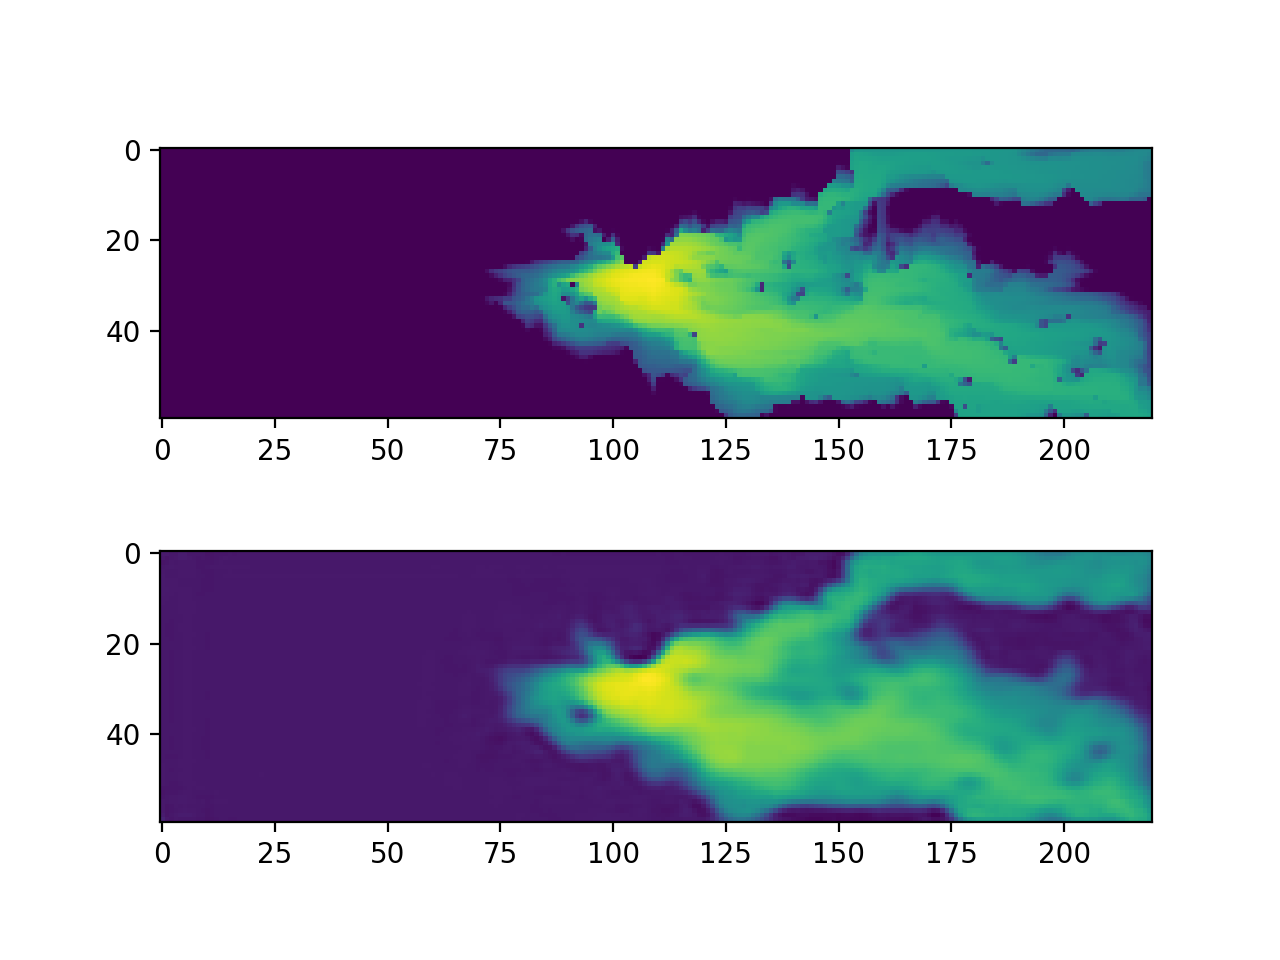

In [18]:
# Sdecoder, Sencoder, Sautoencoder = retrieve_coders('S', Sencoded_shape)
# Sautoencoder.summary()
# check trained autoencoders
interval = np.arange(69,70)

decoded_S = Sautoencoder.predict(Stest_reshaped[interval,])
animate_compare(Stest_reshaped[interval,],decoded_S[:,])

## Scale data and split into sequences for RNN

In [22]:
from sklearn.preprocessing import MinMaxScaler

# def change_sampling_rate(DATA,sampling_rate):
#     # DATA: [n x (60*220)], n is original total sample size,75 is the original batch size
#     batch_size = int(75/sampling_rate) # new batch size
#     New_Data = []
#     for i in range(int(len(DATA)/75)):
#         temp = []
#         for index in range(batch_size):
#             temp.append(DATA[i*75+index*sampling_rate])
#         temp = np.stack(temp)
#         New_Data.append(temp)
#     New_Data = np.concatenate(New_Data,axis=0)
#     return New_Data, batch_size

def crop_data(DATA,start,end,batch_size):
    # DATA: encoded or original data for Saturation/Pressure
    # recommend start = 10, end = 71 (non-inclusive end)
    if end-start>batch_size:
        print('ERROR: batch size too large for specified start and end...')
        return 0
    samples = int(DATA.shape[0]/batch_size)
    cropped_DATA = []
    for i in range(samples):
        cropped_DATA.append(DATA[i*batch_size+start:i*batch_size+end,])
    cropped_DATA = np.concatenate(cropped_DATA)
    batch_size = end-start
    return cropped_DATA, batch_size


def add_setup_data(DATA, RDATA, batch_size):
    # concatenate porosity data with states data (in encoded space)
    # [state at t1, porosity 1; state at t2, porosity 2]
    n = int(len(DATA)/batch_size) # the number of simulations
    if n != len(RDATA):
        print('ERROR: Porosity data does not match States data in length..')
        return 0
    Concatenated_Data = []
    for i in range(n):
        for j in range(batch_size):
            temp = np.concatenate([DATA[i*batch_size+j],RDATA[i]],axis=-1)
            Concatenated_Data.append(temp)
    return np.stack(Concatenated_Data)
    

def create_dataset(Batch_Data, window_len, sampling_rate):
    """
    Batch Data must be inputed
    Takes in a timeseries X to create a dataset such that
    
    X_new = [[X_0,X_1,X_2,...,X_window_len],....[X_end-window_len,....,X_end]]
    Y_new = [X_window_len,....X_end]
    
    added rate for different sampling rates
    """
    X_new = []
    y_new = []
    sample_list = np.array([i*sampling_rate for i in range(window_len)])
    for index in range(len(Batch_Data) - window_len*sampling_rate):        
        X_new.append(Batch_Data[index+sample_list])
        y_new.append(Batch_Data[index+window_len*sampling_rate])
    X_new = np.stack(X_new)
    y_new = np.stack(y_new)
    return X_new,y_new

# def scale_data(X):
#     # input original dataset samples X (x*y)
#     # return normalized data and the corresponding scaler
#     scaler = MinMaxScaler()
#     scaler = scaler.fit(X)
#     print('Min:', scaler.data_min_[0:3], '\nMax: ',scaler.data_max_[0:3])
#     normalized = scaler.transform(X)
#     return normalized, scaler

def prepare_RNN_data(Encoded_data,lookback,batch_size,sampling_rate):
    # assume input is encoded and outputs the tuple containing X and Y for training/ testing
    Out_X = []
    Out_y = []
    if lookback>batch_size:
        print('ERROR: Lookback window size is larger than updated batch size..')
        return 0
    for i in range(int(len(Encoded_data)/batch_size)):
        X_temp, y_temp = create_dataset(Encoded_data[i*batch_size:(i+1)*batch_size,:],lookback, sampling_rate)
        Out_X.append(X_temp)
        Out_y.append(y_temp)
    Out_X = np.concatenate(Out_X,axis = 0)
    Out_y = np.concatenate(Out_y,axis = 0)
    return (Out_X, Out_y)


## LSTM-RNN

In [59]:
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
def trainRNN(lookback,TRAIN,TEST,LSTM_unit,episodes,BS):
    # specify Neural Network architecture
    #     Dense1_unit = 100
    #     LSTM_unit = 30
    # unpack inputs
    X_train, y_train = TRAIN
    X_test, y_test = TEST
    input_dims = X_train.shape[1:] # size of input
    output_dims = y_train.shape[1:]
    dim_prod = int(np.prod(X_train.shape[2:]))
#     if lookback == 1:
#         # change expected output shape if lookback is 1
#         X_train = np.expand_dims(X_train,axis = 1)
#         y_test = np.expand_dims(X_test,axis = 1)
    # build neural net
    RNN = Sequential()
    RNN.add(Reshape((lookback, dim_prod), input_shape=(input_dims)))
    RNN.add(LSTM(50, activation='relu', input_shape=(lookback,dim_prod)))
    RNN.add(Dense((dim_prod), activation = 'sigmoid'))
    RNN.add(Reshape((output_dims), input_shape=([dim_prod])))
    RNN.compile(loss='binary_crossentropy', optimizer='adam')
    history = RNN.fit(X_train, y_train, epochs=episodes, batch_size=BS-lookback, validation_data=(X_test, y_test), verbose=1, shuffle=False)
    # plot history
    plt.figure()
    plt.semilogy(np.array(history.history['loss']), label='Training Error')
    plt.semilogy(np.array(history.history['val_loss']), label='Test Error')
    plt.xlabel('Epoch')
    plt.ylabel('binary_crossentropy')
    plt.legend()
    plt.show()
    RNN.summary()
    return RNN

<IPython.core.display.Javascript object>


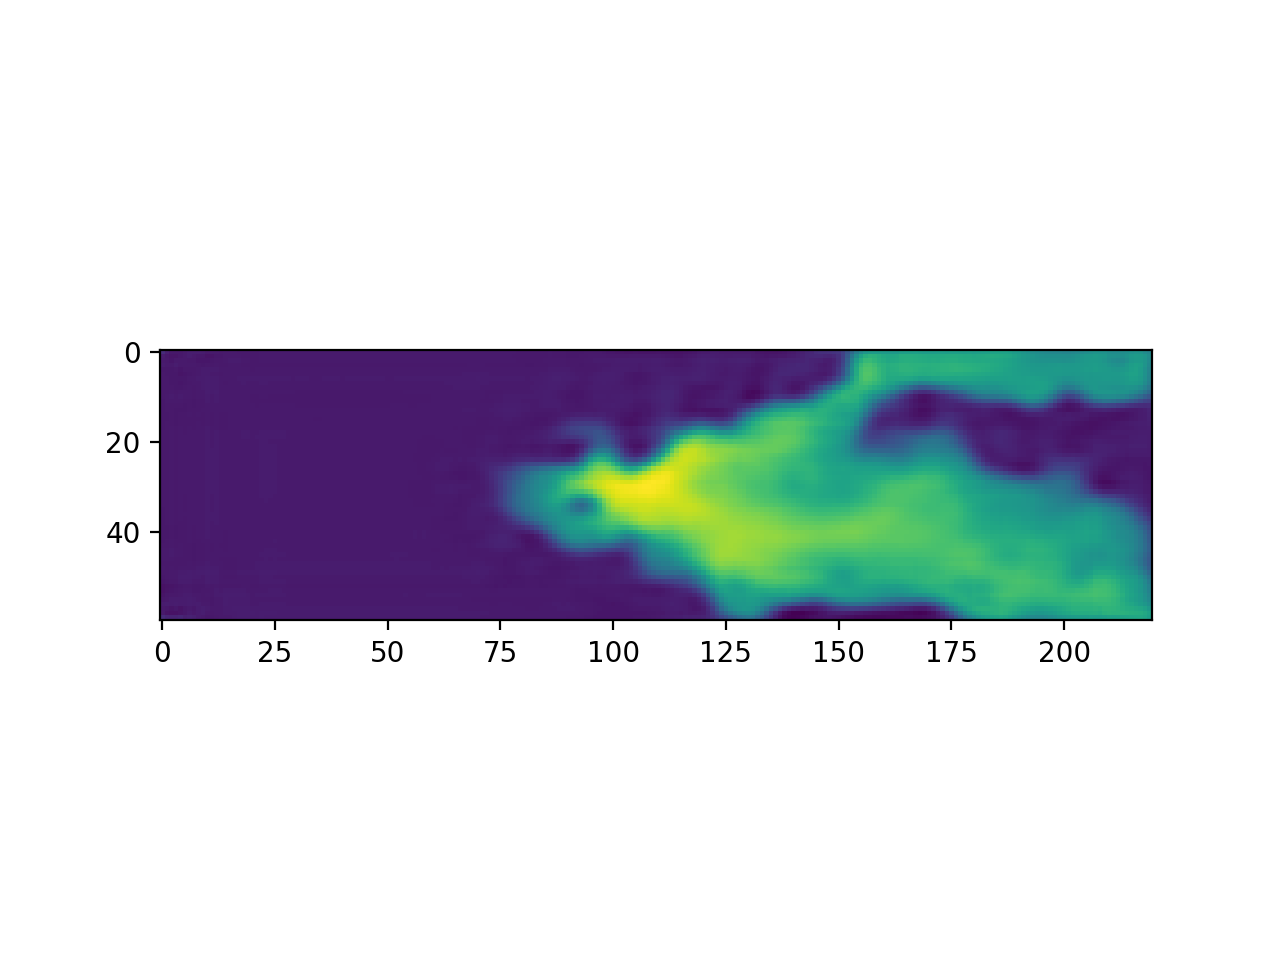

In [102]:
animate_encoded(Stest_stacked_encoded[0:75],Sdecoder,np.arange(8))

(4320, 3, 8, 28, 12)
Train on 4320 samples, validate on 1080 samples
Epoch 1/20
4320/4320 [==============================] - 11s 3ms/step - loss: 0.4027 - val_loss: 0.3395
Epoch 2/20
4320/4320 [==============================] - 7s 2ms/step - loss: 0.3385 - val_loss: 0.3348
Epoch 3/20
4320/4320 [==============================] - 7s 2ms/step - loss: 0.3336 - val_loss: 0.3301
Epoch 4/20
4320/4320 [==============================] - 7s 2ms/step - loss: 0.3298 - val_loss: 0.3278
Epoch 5/20
4320/4320 [==============================] - 7s 2ms/step - loss: 0.3281 - val_loss: 0.3273
Epoch 6/20
4320/4320 [==============================] - 7s 2ms/step - loss: 0.3273 - val_loss: 0.3266
Epoch 7/20
4320/4320 [==============================] - 7s 2ms/step - loss: 0.3265 - val_loss: 0.3256
Epoch 8/20
4320/4320 [==============================] - 7s 2ms/step - loss: 0.3254 - val_loss: 0.3249
Epoch 9/20
4320/4320 [==============================] - 7s 2ms/step - loss: 0.3244 - val_loss: 0.3241
Epoch 10/20


<IPython.core.display.Javascript object>


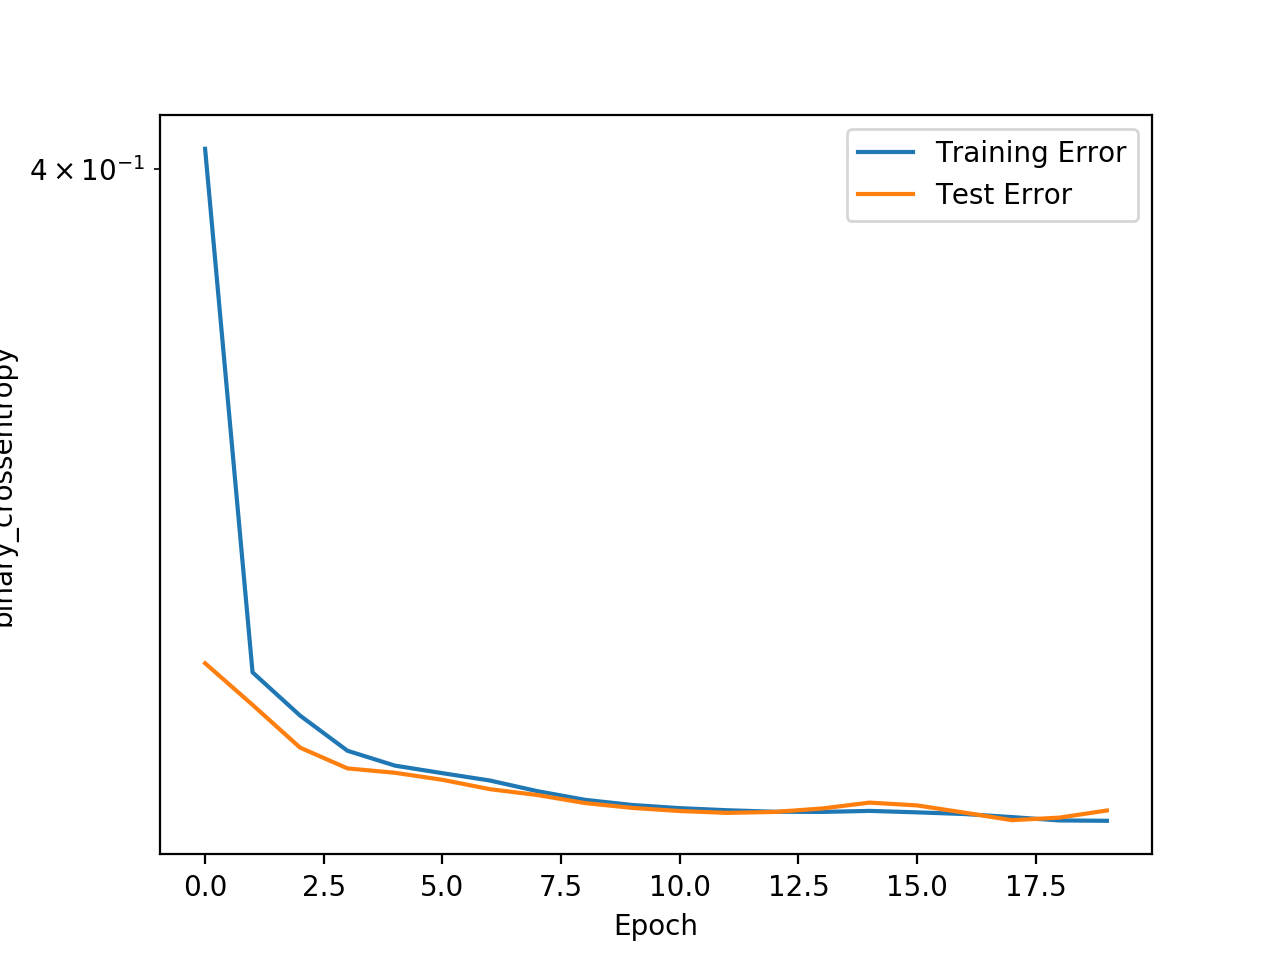

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_7 (Reshape)          (None, 3, 2688)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                547800    
_________________________________________________________________
dense_4 (Dense)              (None, 2688)              137088    
_________________________________________________________________
reshape_8 (Reshape)          (None, 8, 28, 12)         0         
Total params: 684,888
Trainable params: 684,888
Non-trainable params: 0
_________________________________________________________________


In [61]:
# ####### SAMPLE TRAINING OF RNN FOR SATURATION (PADDED WITH ROCK POROSITY) ########
# Sencoded_shape = (8,28,8)
# Rencoded_shape = (8,28,4)
# # retrieve encoders for porosity and saturation
# Sdecoder, Sencoder, Sautoencoder = retrieve_coders('S', Sencoded_shape)
# Rdecoder, Rencoder, Rautoencoder = retrieve_coders('R', Rencoded_shape)
# # encode porosity setups
# Rtrain_encoded = Rencoder.predict(Rtrain_reshaped)
# Rtest_encoded = Rencoder.predict(Rtest_reshaped)
# # change sampling rate of saturation states 
# batch_size = 75 # default value
# start = 10
# end = 70
# Stest_updated,cropped_batch_size = crop_data(Stest_reshaped,start,end,batch_size)
# Strain_updated, cropped_batch_size = crop_data(Strain_reshaped,start,end,batch_size)
# # Stest_updated, batch_size = change_sampling_rate(Stest_reshaped,sampling_rate)
# # Strain_updated, batch_size = change_sampling_rate(Strain_reshaped,sampling_rate)
# print(Strain_updated.shape)
# # encode training and testing data
# Strain_encoded = Sencoder.predict(Strain_updated)
# Stest_encoded = Sencoder.predict(Stest_updated)
# print(Strain_encoded.shape, Rtrain_encoded.shape)
# # update encoded space by padding with setup porosity
# Stest_stacked_encoded = add_setup_data(Stest_encoded, Rtest_encoded, cropped_batch_size)
# Strain_stacked_encoded = add_setup_data(Strain_encoded, Rtrain_encoded, cropped_batch_size)
# transform encoded data into trainable sets
lookback = 3
sampling_rate = 2 
STRAIN = prepare_RNN_data(Strain_stacked_encoded,lookback,cropped_batch_size, sampling_rate)
STEST = prepare_RNN_data(Stest_stacked_encoded,lookback,cropped_batch_size, sampling_rate)
# prepare data for validating and visualization later
STEST_single = prepare_RNN_data(Stest_encoded,lookback,cropped_batch_size, sampling_rate) 
_, original_y = prepare_RNN_data(Stest_updated,lookback,cropped_batch_size, sampling_rate)
print(STRAIN[0].shape)
# train model using training and testing sets
SRNN_model = trainRNN(lookback,STRAIN,STEST,50,20,batch_size)

In [72]:
# benchmark training of Feed-foward Neural Network
def trainFFN(lookback,TRAIN,TEST,Dense_unit,episodes,BS):
    # specify Neural Network architecture
    #     Dense1_unit = 100
    #     LSTM_unit = 30
    # unpack inputs
    X_train, y_train = TRAIN
    X_test, y_test = TEST
    input_dims = X_train.shape[1:] # size of input
    output_dims = y_train.shape[1:]
    dim_prod = int(np.prod(X_train.shape[2:]))
#     if lookback == 1:
#         # change expected output shape if lookback is 1
#         X_train = np.expand_dims(X_train,axis = 1)
#         y_test = np.expand_dims(X_test,axis = 1)
    # build neural net
    FFN = Sequential()
    FFN.add(Reshape(([lookback*dim_prod]), input_shape=(input_dims)))
    FFN.add(Dense((Dense_unit), activation = 'sigmoid'))
    FFN.add(Dense((dim_prod), activation = 'sigmoid'))
    print(output_dims)
    FFN.add(Reshape((output_dims), input_shape=([dim_prod])))
    FFN.compile(loss='mean_absolute_percentage_error', optimizer='adam')
    history = FFN.fit(X_train, y_train, epochs=episodes, batch_size=BS-lookback, validation_data=(X_test, y_test), verbose=1, shuffle=True)
    # plot history
    plt.figure()
    plt.semilogy(np.array(history.history['loss']), label='Training Error')
    plt.semilogy(np.array(history.history['val_loss']), label='Test Error')
    plt.xlabel('Epoch')
    plt.ylabel('mean_absolute_percentage_error')
    plt.legend()
    plt.show()
    FFN.summary()
    return FFN



## Sequential Test Functions

In [19]:
from numpy import linalg as LA
def updateX(model,X_current,lookback,Porosity_encoded,STATE_encoded_shape):
    # take in the current X sample and update it using LSTM trained neural net
    # originally [X1 X2 .. X_lookback] -> [X2 .. X_lookback+1]
#     print('X_now:',X_current.shape)
    
    if Porosity_encoded !=[]:
        temp = []
        for i in range(len(X_current)):
            temp.append(np.concatenate([X_current[i], Porosity_encoded],axis=-1))
        X_stacked = np.stack(temp)
    else:
        X_stacked = X_current
#     print(X_current.shape)
    X_c_train = np.expand_dims(X_stacked, axis=0)
    x_stacked_plusone = model.predict(X_c_train,batch_size=None, verbose=0, steps=None)
    x_plusone = x_stacked_plusone[:,:,:,0:STATE_encoded_shape[-1]]
    if lookback == 1:
        X_next = x_plusone
    else:
#         print(X_current[1:,].shape,x_plusone.shape)
        X_next = np.vstack((X_current[1:,],x_plusone))
#         print('X_next:',X_next.shape)
    return X_next,x_plusone

def cumulative_test(X_test, y_test, original_y, lookback, RNN_model, State_decoder, STATE_encoded_shape, Porosity_encoded, batch_size):
    # perform cumulative testing
    # X_test should only have length of batch_size
    # X_test and y_test: [state_encoded]
    # error analysis and comparison will be done in the original space however
    # Porosity_encoded for the specifc interval will be used
    m = y_test.shape[0]    # total number of samples to loop through
    if m>batch_size-lookback:
        print('ERROR: X_test should have length of batch_size-lookback')
        return 0
    i = start
    X_current = X_test[start,] # both X_test should be the same
    errors = []
    predicted_y = []
    while i < m:
        X_next,y_predicted = updateX(RNN_model,X_current,lookback,Porosity_encoded)
        
        # update X and error term
        X_current = X_next
        y_predicted_original = State_decoder.predict(y_predicted)
        errors.append(LA.norm(original_y[i,]-y_predicted_original)/LA.norm(original_y[i,]))
        predicted_y.append(y_predicted_original)
        if errors[i-start] >0.2:
            predicted_y = np.stack(predicted_y)
            errors = np.array(errors)
            break
        i += 1
    predicted_y = np.stack(predicted_y)
    errors = np.array(errors)
    return errors, predicted_y

def non_cumulative_test(X_test, y_test, original_y, RNN_model, State_decoder, STATE_encoded_shape, Porosity_encoded, batch_size, lookback):
    m = y_test.shape[0]    # total number of samples to loop through
    errors = np.zeros(m)
    predicted_y = np.zeros(original_y.shape)
    for i in range(m):
        _, y_predicted = updateX(RNN_model,X_test[i,],lookback, Porosity_encoded, STATE_encoded_shape)
        y_predicted_original = State_decoder.predict(y_predicted)
        errors[i] = LA.norm(original_y[i,]-y_predicted_original)/LA.norm(original_y[i,])
        predicted_y[i,:] = y_predicted_original
    return errors, predicted_y

## Saturation Test

In [25]:
####### SAMPLE TRAINING OF RNN FOR SATURATION (PADDED WITH ROCK POROSITY) ########
Sencoded_shape = (8,28,8)
# Rencoded_shape = (8,28,4)
# retrieve encoders for porosity and saturation
Sdecoder, Sencoder, Sautoencoder = retrieve_coders('S', Sencoded_shape)
# Rdecoder, Rencoder, Rautoencoder = retrieve_coders('R', Rencoded_shape)
# encode porosity setups
# Rtrain_encoded = Rencoder.predict(Rtrain_reshaped)
# Rtest_encoded = Rencoder.predict(Rtest_reshaped)
# change sampling rate of saturation states 
batch_size = 75 # default value
start = 0
end = 75
Stest_updated,cropped_batch_size = crop_data(Stest_reshaped,start,end,batch_size)
# Strain_updated, cropped_batch_size = crop_data(Strain_reshaped,start,end,batch_size)
# Stest_updated, batch_size = change_sampling_rate(Stest_reshaped,sampling_rate)
# Strain_updated, batch_size = change_sampling_rate(Strain_reshaped,sampling_rate)
print(Strain_updated.shape)
# encode training and testing data
# Strain_encoded = Sencoder.predict(Strain_updated)
Stest_encoded = Sencoder.predict(Stest_updated)



(6000, 60, 220, 1)


In [34]:
# prepare for analysis, generate data for comparison
lookback = 3
sampling_rate = 2
for lookback in range(3,4):
    for sampling_rate in range(2,3):
        SRNN = load_model('SRNN_'+str(lookback)+'_'+str(sampling_rate)+'_pure.h5')
        Incre = cropped_batch_size-lookback*sampling_rate
        SRNN.summary()
        # prepare data for validating and visualization later
        STEST = prepare_RNN_data(Stest_encoded,lookback,cropped_batch_size, sampling_rate) 
        _, original_y = prepare_RNN_data(Stest_updated,lookback,cropped_batch_size, sampling_rate)

        X,y = STEST
        # decoded_y = Sdecoder.predict(y)
        print(y.shape,original_y.shape)

        item = 2
        Interval = np.arange(Incre*item,Incre*(item+1)) # interval for testing sequentially
        # switch out between decoded_y and original_y for different comparisons
        errors, predicted_y = non_cumulative_test(X[Interval,], y[Interval,], original_y[Interval,], SRNN, 
                                              Sdecoder, Sencoded_shape, [], cropped_batch_size,lookback)
        # animate_compare(original_y[Interval,],predicted_y)
        # plt.figure()
        # plt.title('Error Plot'+'Lookback')
        # plt.plot(np.arange(len(errors))+lookback*sampling_rate+1, errors, 'r--')
        # plt.xlabel('Steps')
        # plt.ylabel('2 Norm Error')
        print('Lookback:'+str(lookback)+', Sampling_Rate:'+str(sampling_rate)+' ----',np.mean(errors))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_25 (Reshape)         (None, 3, 1792)           0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 100)               757200    
_________________________________________________________________
dense_13 (Dense)             (None, 1792)              180992    
_________________________________________________________________
reshape_26 (Reshape)         (None, 8, 28, 8)          0         
Total params: 938,192
Trainable params: 938,192
Non-trainable params: 0
_________________________________________________________________
(1380, 8, 28, 8) (1380, 60, 220, 1)
Lookback:3, Sampling_Rate:2 ---- 0.13076783813860104


In [62]:
# prepare for analysis, generate data for comparison
Incre = batch_size-lookback*sampling_rate
X,y = STEST_single
# original_X, original_y = STEST_original
# decoded_y = Sdecoder.predict(y)
print(y.shape,original_y.shape, decoded_y.shape)

(1080, 8, 28, 8) (1080, 60, 220, 1) (1080, 60, 220, 1)


In [56]:
print(X.shape,y.shape)

(1080, 3, 8, 28, 8) (1080, 8, 28, 8)


In [57]:
20*(60-3*2)

1080

<IPython.core.display.Javascript object>


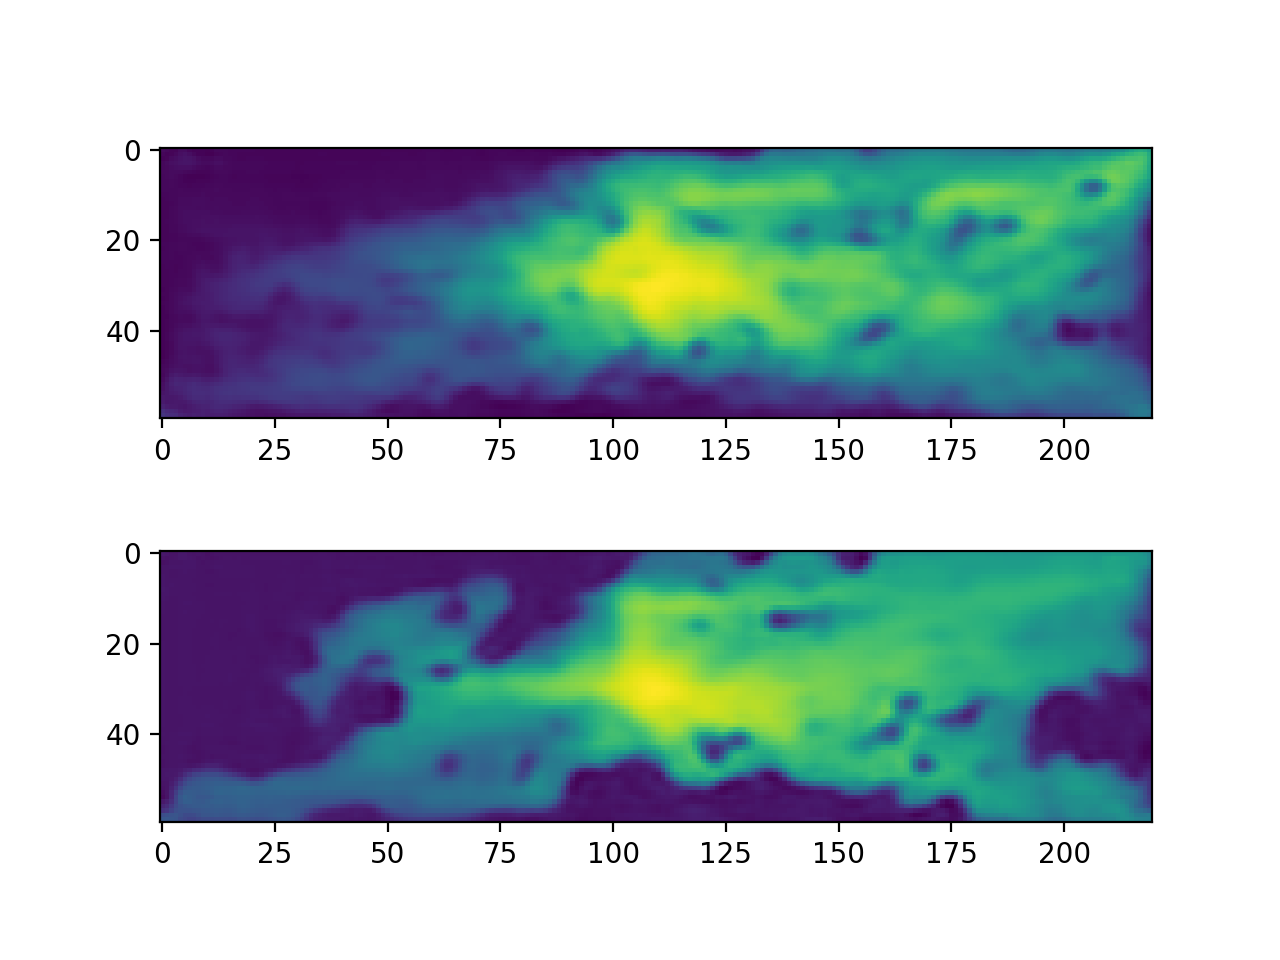

<IPython.core.display.Javascript object>


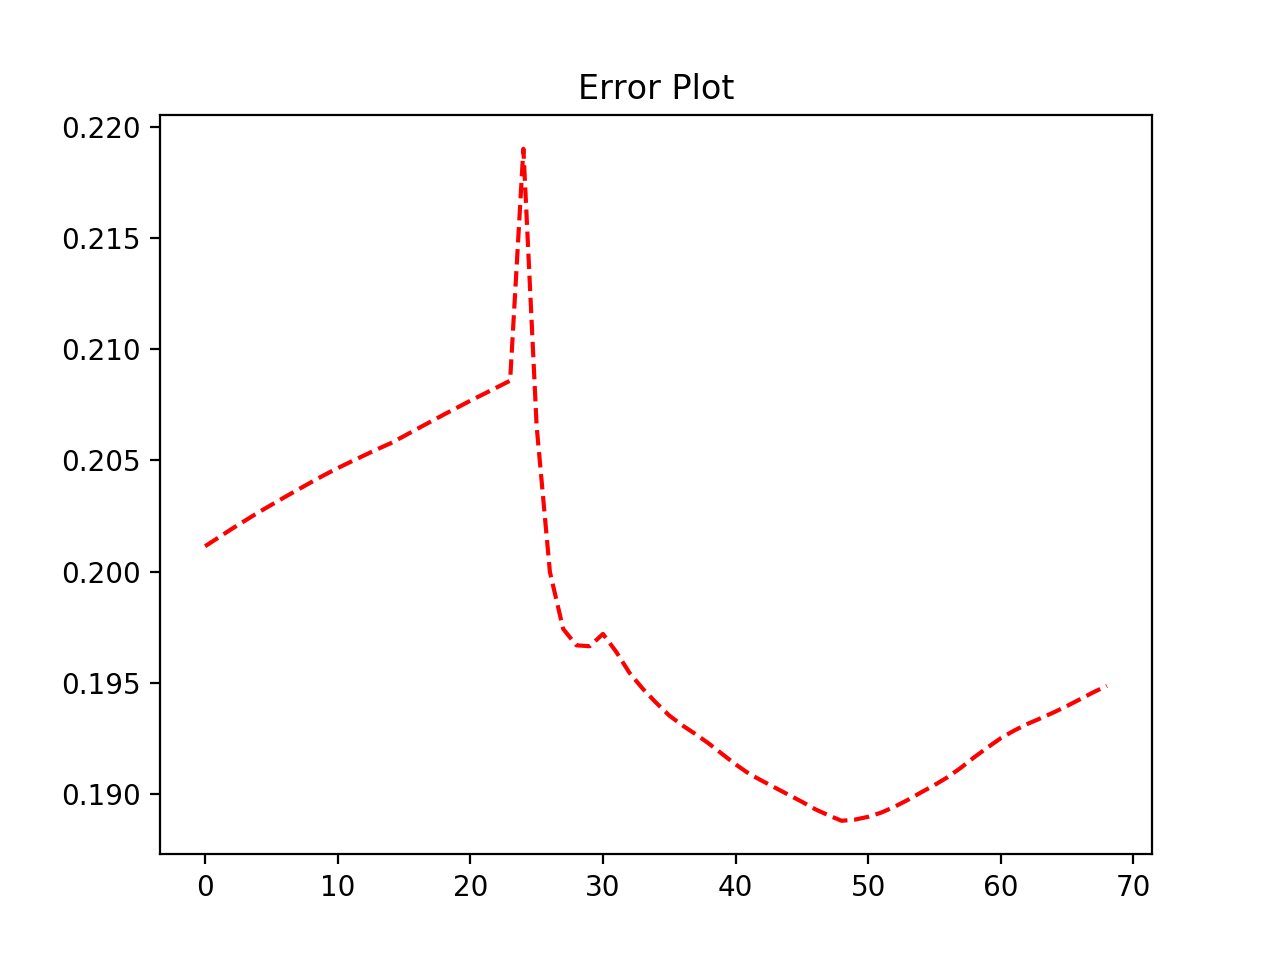

In [67]:
Interval = np.arange(Incre*2,Incre*3) # interval for testing sequentially
# switch out between decoded_y and original_y for different comparisons
errors, predicted_y = non_cumulative_test(X[Interval,], y[Interval,], decoded_y[Interval,], SRNN_model, 
                                      Sdecoder,Rtest_encoded[2], cropped_batch_size)
animate_compare(predicted_y,decoded_y[Interval,])
plt.figure()
plt.title('Error Plot')
plt.plot(np.arange(len(errors)), errors, 'r--')

<IPython.core.display.Javascript object>


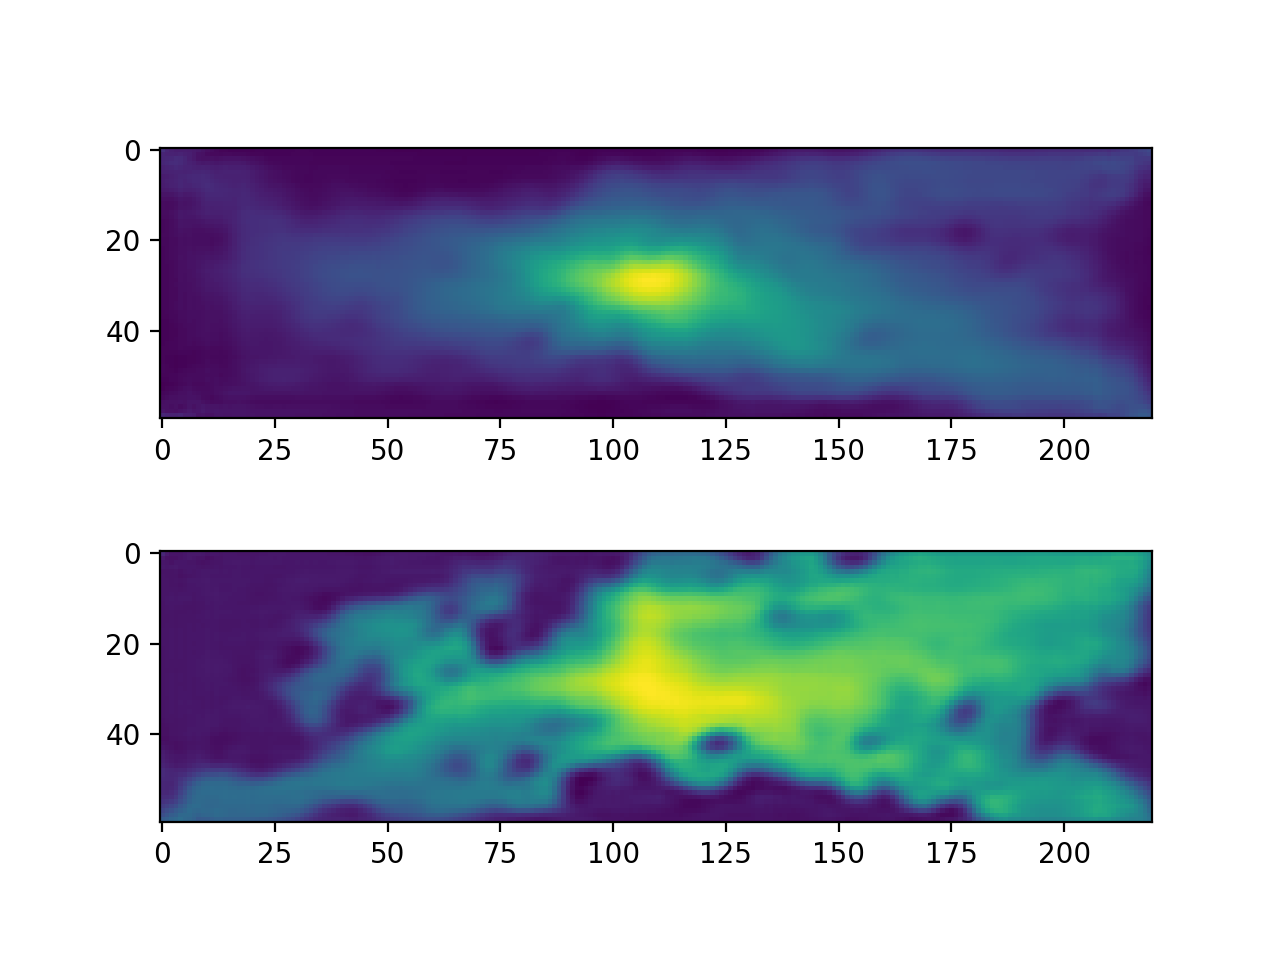

<IPython.core.display.Javascript object>


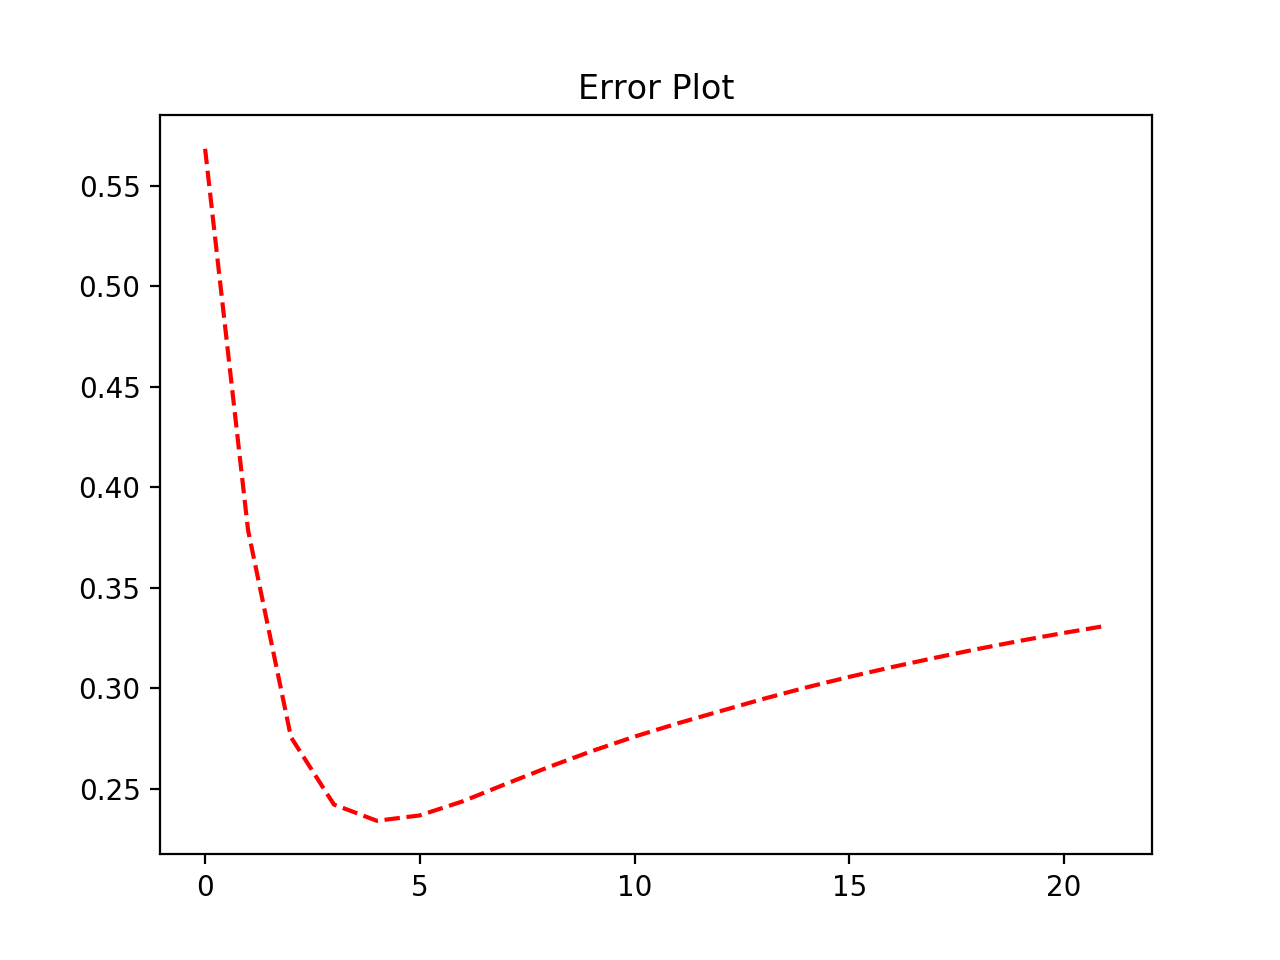

In [83]:
errors, predicted_y = cumulative_test(X[Interval,], y[Interval,], decoded_y[Interval,], lookback, FFN_model, decoder)
animate_compare(predicted_y, decoded_y[Interval,])
plt.figure()
plt.title('Error Plot')
plt.plot(np.arange(len(errors)), errors, 'r--')

## Pressure Test

Min: [27580000. 27584000. 27588000.] 
Max:  [37017000. 52613000. 59979000.]
(6000, 60, 220, 1)


<IPython.core.display.Javascript object>


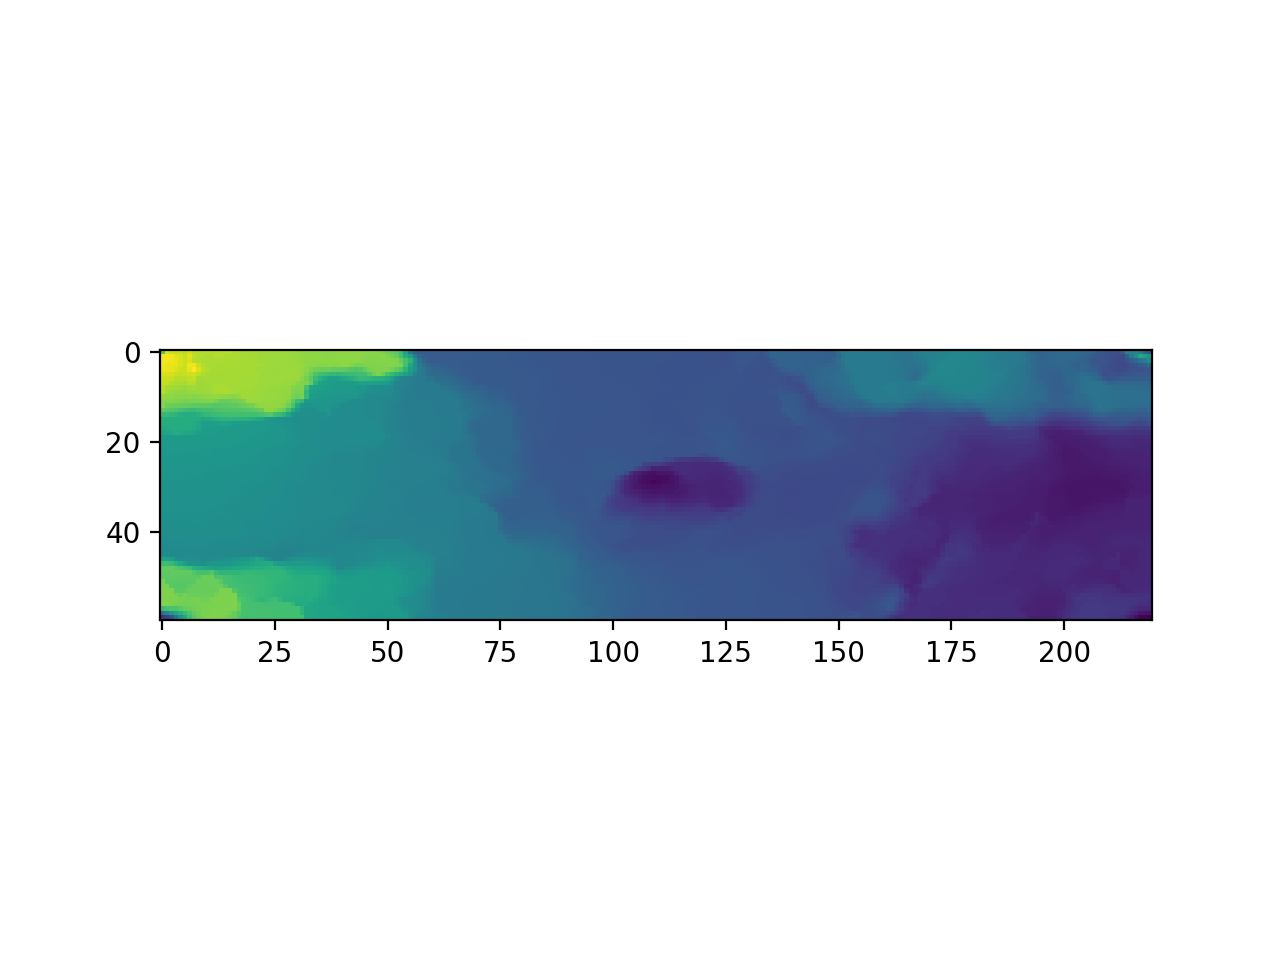

In [94]:

PTRAIN = pullseries(PRESSURE_PATH, 'pressure', np.arange(1,81))
PTEST = pullseries(PRESSURE_PATH, 'pressure', np.arange(81,101))

Ptrain, Pscaler = scale_data(PTRAIN) # scale original data
Ptest = Pscaler.transform(PTEST)

Ptrain_reshaped = np.reshape(Ptrain,(len(Ptrain), 60, 220, 1),order= 'F')
Ptest_reshaped = np.reshape(Ptest,(len(Ptest), 60, 220, 1),order= 'F')



(6000, 8, 28, 8)


<IPython.core.display.Javascript object>


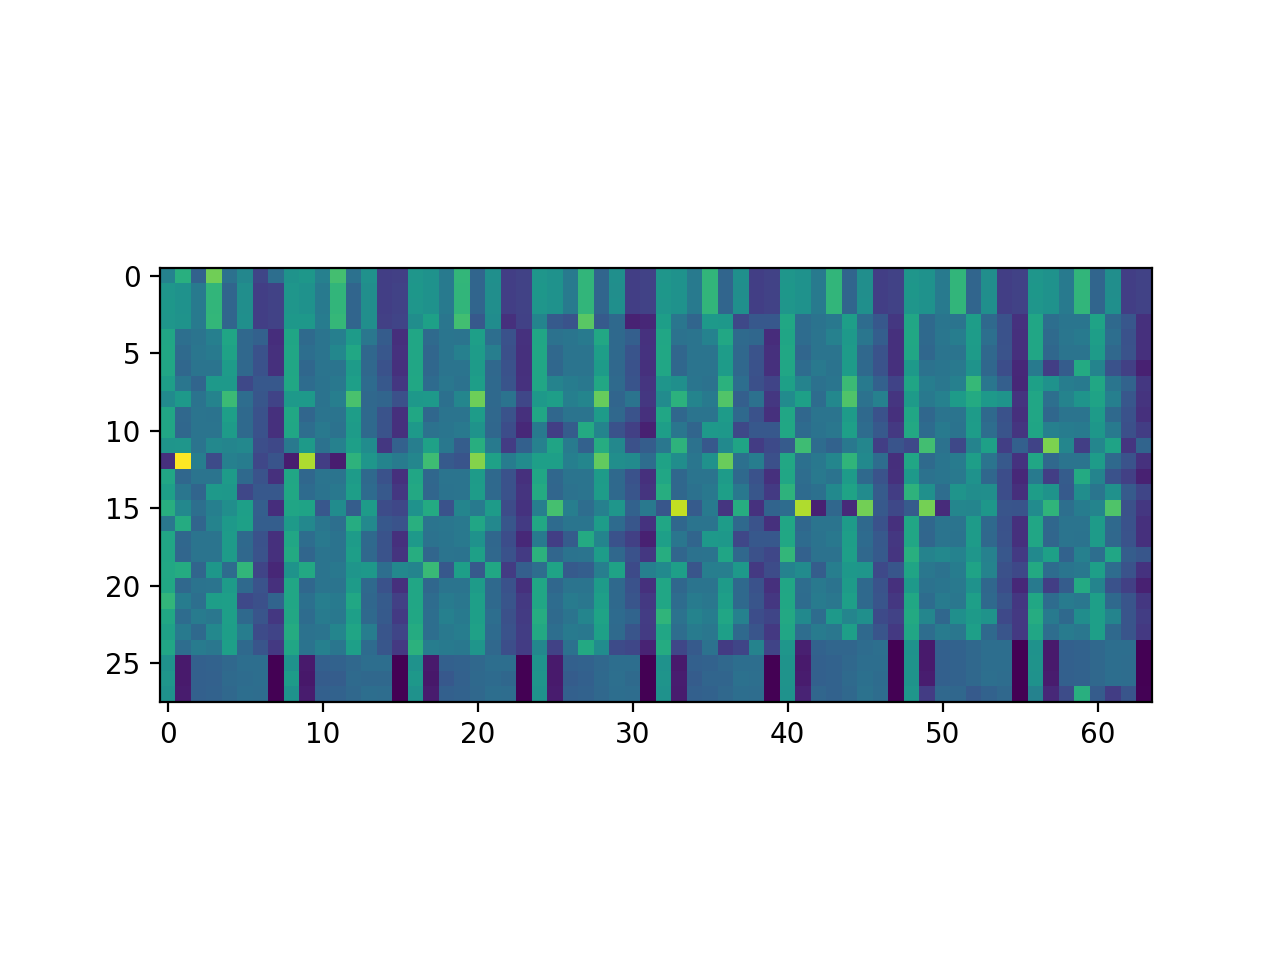

<IPython.core.display.Javascript object>


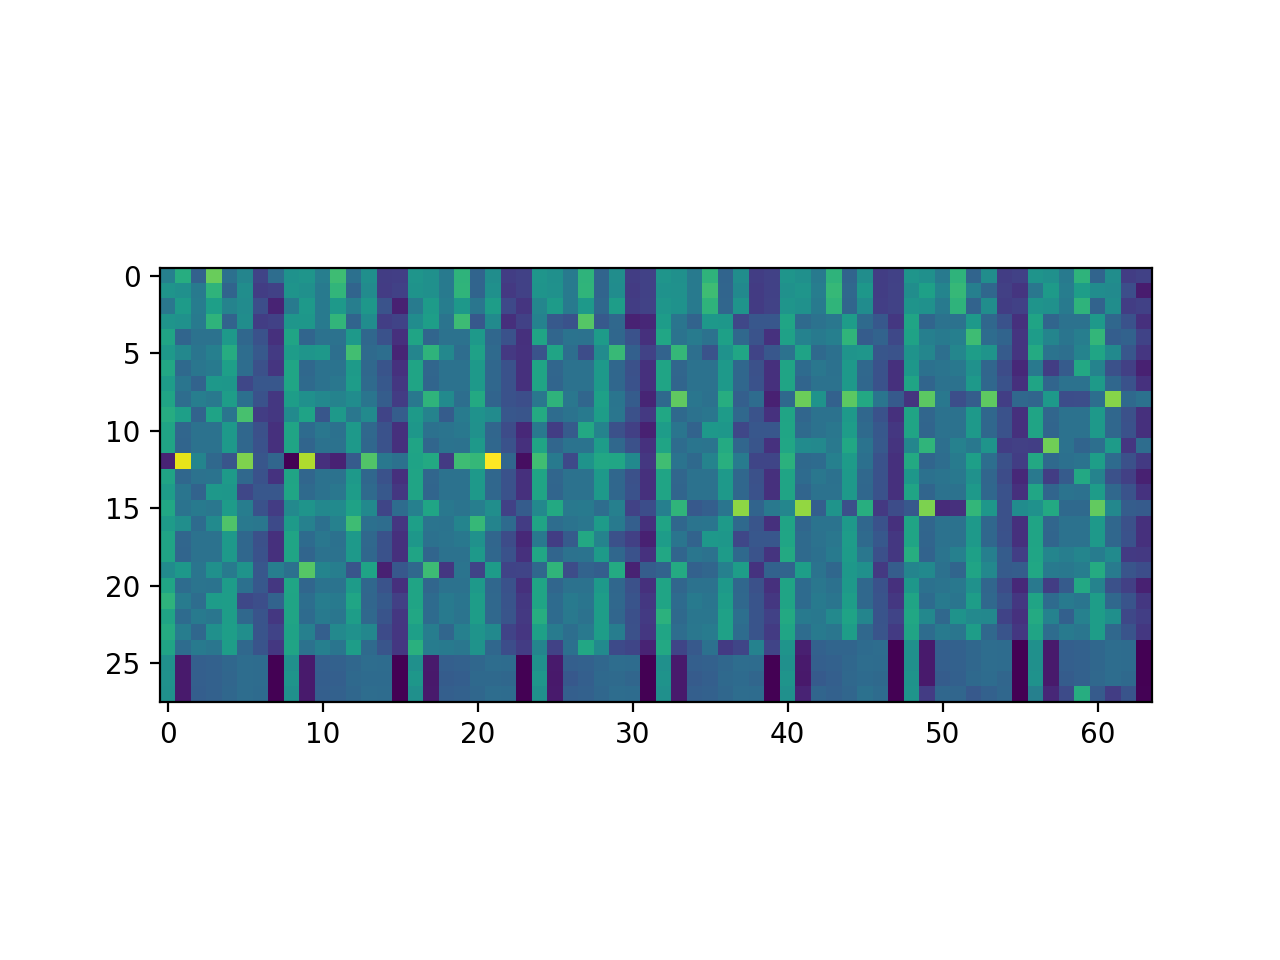

In [258]:
print(Strain_encoded.shape)
plt.figure()
plt.imshow(np.reshape(Strain_encoded[10,],(28,64)))
plt.figure()
plt.imshow(np.reshape(Strain_encoded[85,],(28,64)))